## Imports

In [4]:
import os
import re
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Ensure inline plotting for notebooks
%matplotlib inline

## Configuration

In [16]:
# ----------------- USER CONFIGURATION -----------------

# 1. Where are the images located?
base_path = "/home/phd2/Documenti/embryo/embryo_to_send_gradcam/correct_blasto/ConvTran/D2015.11.03_S1380_I141_2/overlay_farneback"

# 2. What is the common start of the filenames? 
# (e.g. if file is "flow_D2015...jpg", put "flow_D2015")
file_prefix = "flow_D2015.11.03_S1380_I141_2"

# 3. What are the 5 starting frame NUMBERS? (Integers only)
start_frames = [8, 103, 157, 323, 477]

# 4. Output settings
save_path = "/home/phd2/Documenti/embryo/mosaic_5x5.png"
tile_size = 512
sequence_length = 5  # How many frames per row

# ------------------------------------------------------

## Helpers

In [17]:
def get_frame_index(filename):
    """
    Extracts the frame number from the filename.
    Looks for pattern: _(digits)_0_ 
    """
    match = re.search(r'_(\d+)_0_', filename)
    if match:
        return int(match.group(1))
    return None

def map_folder_indices(path, prefix):
    """
    Scans the folder and returns a dict: {frame_number: full_filename}
    This solves the issue of unknown timestamps in filenames.
    """
    if not os.path.isdir(path):
        raise FileNotFoundError(f"Directory not found: {path}")
        
    index_map = {}
    valid_files = [f for f in os.listdir(path) if f.startswith(prefix) and f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    
    for fname in valid_files:
        idx = get_frame_index(fname)
        if idx is not None:
            index_map[idx] = fname
            
    return index_map

def center_crop_resize(img, target_size):
    w, h = img.size
    side = min(w, h)
    left = (w - side) // 2
    top = (h - side) // 2
    cropped = img.crop((left, top, left + side, top + side))
    return cropped.resize((target_size, target_size), Image.LANCZOS)

def create_placeholder(size, label):
    img = Image.new("RGB", size, (240, 240, 240))
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 14)
    except:
        font = ImageFont.load_default()
    
    draw.text((10, 10), "Missing Frame", fill=(200, 0, 0), font=font)
    draw.text((10, 30), label, fill=(50, 50, 50), font=font)
    return img

## Execute

Scanning directory: /home/phd2/Documenti/embryo/embryo_to_send_gradcam/correct_blasto/ConvTran/D2015.11.03_S1380_I141_2/overlay_farneback...
Found 556 valid images matching prefix 'flow_D2015.11.03_S1380_I141_2'
Processing Row 1: Starting at frame 8
Processing Row 2: Starting at frame 103
Processing Row 3: Starting at frame 157
Processing Row 4: Starting at frame 323
Processing Row 5: Starting at frame 477

Saved mosaic to: /home/phd2/Documenti/embryo/mosaic_5x5.png


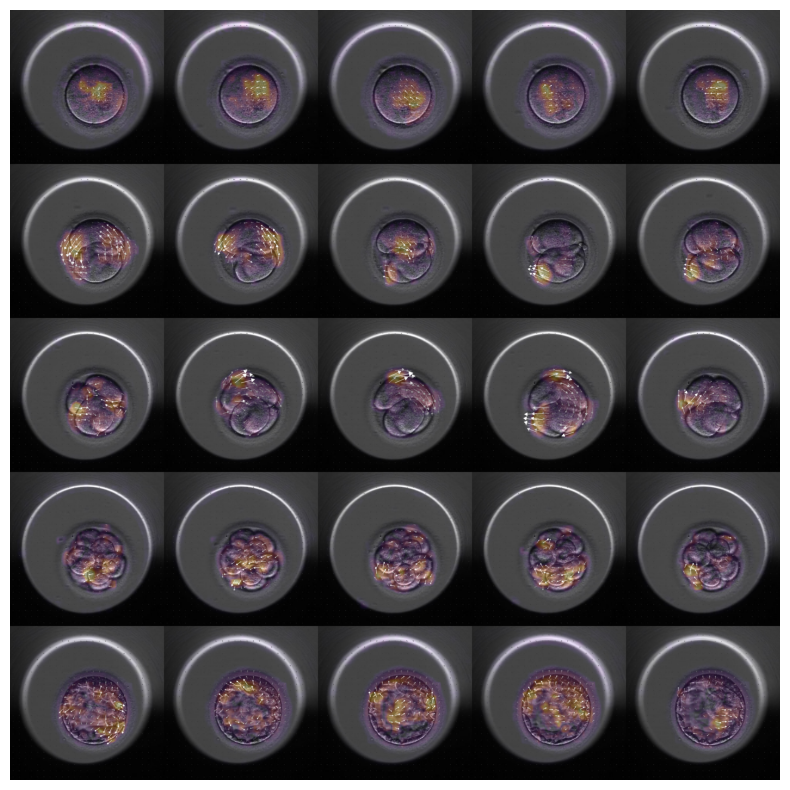

In [18]:
def generate_mosaic():
    print(f"Scanning directory: {base_path}...")
    
    # 1. Map all existing files in the directory by their frame index
    file_map = map_folder_indices(base_path, file_prefix)
    print(f"Found {len(file_map)} valid images matching prefix '{file_prefix}'")

    mosaic_w = sequence_length * tile_size
    mosaic_h = len(start_frames) * tile_size
    mosaic = Image.new("RGB", (mosaic_w, mosaic_h), (255, 255, 255))

    # 2. Iterate through rows (start frames)
    for row_idx, start_num in enumerate(start_frames):
        print(f"Processing Row {row_idx+1}: Starting at frame {start_num}")
        
        # 3. Iterate through columns (sequential frames)
        for col_idx in range(sequence_length):
            current_frame_num = start_num + col_idx
            
            x = col_idx * tile_size
            y = row_idx * tile_size
            
            # Lookup the filename for this specific frame number
            fname = file_map.get(current_frame_num)
            
            if fname:
                full_path = os.path.join(base_path, fname)
                try:
                    img = Image.open(full_path).convert("RGB")
                    img = center_crop_resize(img, tile_size)
                    mosaic.paste(img, (x, y))
                except Exception as e:
                    print(f"  Error reading {fname}: {e}")
                    ph = create_placeholder((tile_size, tile_size), f"Err: {fname}")
                    mosaic.paste(ph, (x, y))
            else:
                # Frame missing from folder
                label = f"Frame {current_frame_num}\nnot found"
                ph = create_placeholder((tile_size, tile_size), label)
                mosaic.paste(ph, (x, y))

    # 4. Save and Show
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    mosaic.save(save_path, dpi=(500, 500))
    print(f"\nSaved mosaic to: {save_path}")

    # Display in Notebook
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(mosaic)
    plt.show()

# Run the process
generate_mosaic()